The original version can be found [here](https://www.cs.ucr.edu/~eamonn/100_Time_Series_Data_Mining_Questions__with_Answers.pdf). This is to reproduce that document using STUMPY API and can be used by python enthusiast.

In [161]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.io

import stumpy

In [162]:
def get_path_to_data_dir(Qnum):
    """
    Given the string value of Question number, Qnum, return the path to the data
    """
    return f"./Tutorial_Applications/{Qnum}/"

# Questions on Time Series Mining...

1. [Do I have this pattern in my data?](#Do_I_have_seen_this)
2. [Are there any repeated patterns in my data?](#Repeated_patterns)
3. [What are the three most unusual days in this three month long dataset?](#unusual_patterns)
4. [Is there any pattern that is common to these two time series?](#pattern_in_two_series)
5. [How do these two time series differ in terms of alignment?](#alignment)
6. [Find the most conserved pattern that happens at least once every two days in this datase](#motifs)

<a id='Do_I_have_seen_this'></a>
## 1. Do I have pattern `Q` in my data `T`? 
(More accuractely: what is the closest pattern to `Q` in my data `T`?)

The data is what collected from an accelerator mpunted on a dog robot. It walks on a carpet and we save this data as `Q`. Now, the robot walks on cement, then on carpet, and then on cement. We save the latter data in `T`. So, Let's detect `walk-on-carpet` part in `T`!

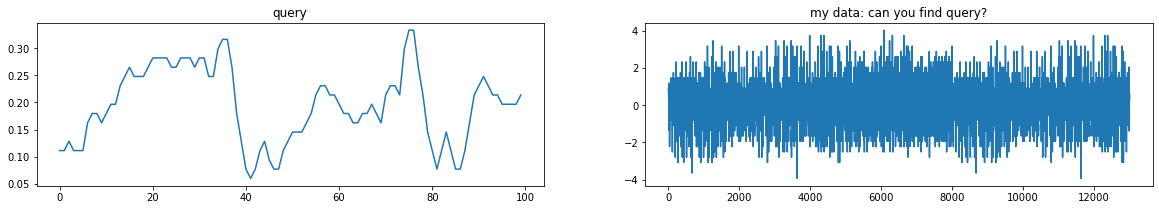

In [212]:
stumpy.config.STUMPY_EXCL_ZONE_DENOM = 2 # according to MATLAB

data_dir = get_path_to_data_dir("Q1")

Q = pd.read_csv(data_dir + "carpet_query.txt", header=None)
Q = np.squeeze(Q.to_numpy())

T = pd.read_csv(data_dir + "robot_dog.txt", header=None)
T = np.squeeze(T.to_numpy())


# plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 3))

axs[0].plot(Q)
axs[0].set_title("query")

axs[1].plot(T)
axs[1].set_title("my data: can you find query?")

plt.show()

we prefer to normalize patterns before measuring their similarity. This is the default setting in STUMPY. You can explore
matching without normalization by setting `normalize=False`

In [213]:
out = stumpy.match(Q, T, max_distance=np.inf, max_matches=1)
start_indices = out[:, 1]
print(start_indices)

[7479]


Note that we set `max_matches=1`, so we found the first NN to Q in data `T`.

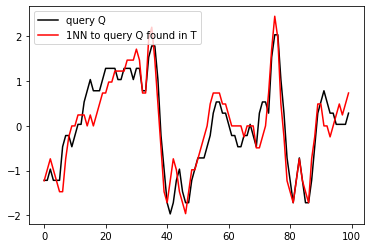

In [214]:
m = len(Q) # lenght of query
idx = start_indices[0]
Q_match = T[idx : idx + m]

Q_znorm = stumpy.core.z_norm(Q)
Qmatch_znorm = stumpy.core.z_norm(Q_match)

plt.plot(Q_znorm, color='k', label='query Q')
plt.plot(Qmatch_znorm, color='r', label=f'1NN to query Q found in T')
plt.legend()
plt.show()

<a id='Repeated_patterns'></a>
## 2. Are there any repeated patterns in my data?  
(more accurately: what is the best pair of repeated patterns in my data?)

The dataset is an hour of EOG (eye movement) data of a sleeping patient, sampled at 100 Hz.

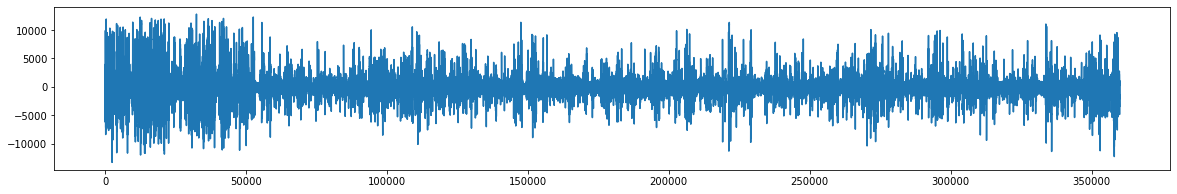

In [215]:
data_dir = get_path_to_data_dir("Q2")
data_dict = scipy.io.loadmat(data_dir + 'eog_sample.mat')
T = np.squeeze(data_dict['eog_sample']).astype(np.float64)

plt.figure(figsize=(20, 3))
plt.plot(T)
plt.show()

We are looking for pair of patterns that are very close to each other!

In [217]:
m = 400 # lenght of pattern of our interest (with 100HZ, this means we are looking for 4-second patterns)
stumpy.config.STUMPY_EXCL_ZONE_DENOM = 1 # according to MATLAB

In [218]:
mp = stumpy.scrump(T, m, s=m//4, pre_scrump=True)

In [223]:
prev_P = mp.P_

diff_lst = []
n_iter = 10
for itr in range(n_iter):
    print(itr, end='-->')
    mp.update()
    new_P = mp.P_
    
    v = np.mean(np.abs(new_P - prev_P))
    diff_lst.append(v)
    
    prev_P = new_P

0-->1-->2-->3-->4-->5-->6-->7-->8-->9-->

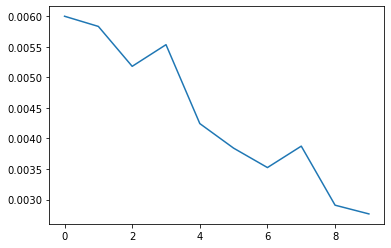

In [224]:
plt.plot(diff_lst)
plt.show()

In [225]:
# another 10 updates

diff_lst_attempt = []
for itr in range(n_iter):
    print(itr, end='-->')
    mp.update()
    new_P = mp.P_
    
    v = np.mean(np.abs(new_P - prev_P))
    diff_lst_attempt.append(v)
    
    prev_P = new_P

0-->1-->2-->3-->4-->5-->6-->7-->8-->9-->

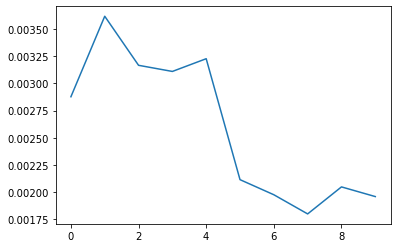

In [226]:
plt.plot(diff_lst_attempt)
plt.show()

In [227]:
last_P = new_P
idx = np.argmin(last_P)
print('idx: ', idx)

idx:  9709


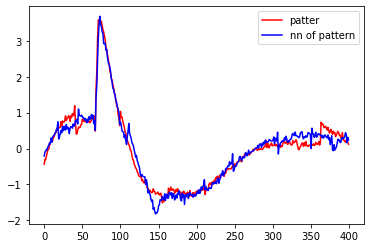

In [230]:
nn_idx = mp.I_[idx]

S_A = T[idx : idx + m]
S_A_nn = T[nn_idx : nn_idx + m]

S_A = stumpy.core.z_norm(S_A)
S_A_nn = stumpy.core.z_norm(S_A_nn)

plt.plot(S_A, color='r', label='patter')
plt.plot(S_A_nn, color='b', label='nn of pattern')
plt.legend()
plt.show()

<a id='unusual_patterns'></a>
## 3. What are the three most unusual days in this three month long dataset?

The datasets is Taxi demand, in New York City, in the last three months of a year, with resolution of 30min.
(discrepency between STUMPY and matlab)

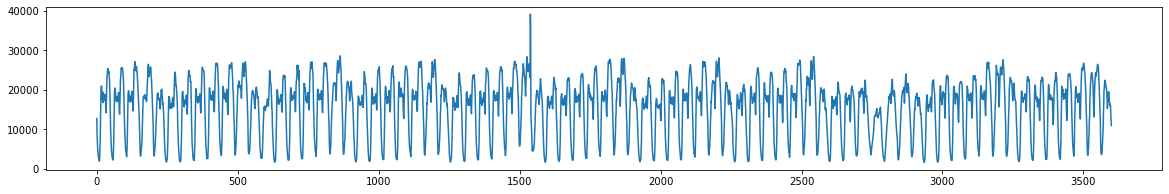

In [231]:
data_dir = get_path_to_data_dir("Q3")
T = pd.read_csv(data_dir + "taxi_3_months.txt", header=None)
T = np.squeeze(T.to_numpy()).astype(np.float64)

plt.figure(figsize=(20, 3))
plt.plot(T)
plt.show()

In [275]:
m = 100 # about two days long
stumpy.config.STUMPY_EXCL_ZONE_DENOM = 1 # not provided in MATLAB! But, I set it to 1!

excl_zone = int(math.ceil(m / stumpy.config.STUMPY_EXCL_ZONE_DENOM))

In [276]:
mp = stumpy.stump(T, m, normalize=True)
P = mp[:, 0].astype(np.float64)
I = mp[:, 1].astype(np.int64)

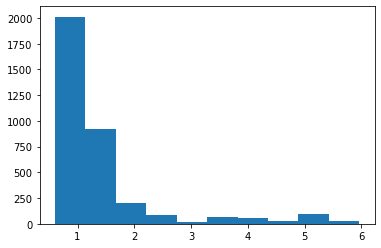

In [277]:
plt.hist(P)
plt.show()

In [278]:
n_unusual = 5 # number of unusual days I am looking for

P_copy = P.copy() # to make sure we do not change P as we may need it for other purposes
lst = []
for _ in range(n_unusual):
    idx = np.argmax(P_copy)
    lst.append(idx)
    
    stumpy.core.apply_exclusion_zone(P_copy, idx, excl_zone, -1.0) 

print(lst)

[2687, 2789, 1485, 554, 3448]


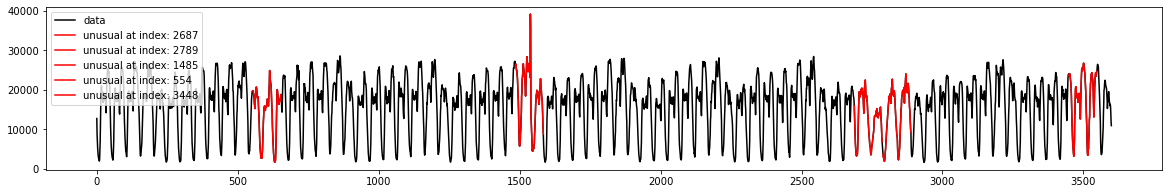

In [279]:
# let's see them

plt.figure(figsize=(20, 3))
plt.plot(T, color='k', label='data')
for idx in lst:
    plt.plot(np.arange(idx, idx+m), T[idx : idx + m], color='r', label=f'unusual at index: {idx}')

plt.legend()
plt.show()

<a id='pattern_in_two_series'></a>
## 4. Is there any pattern that is common to these two time series?

We have two sequence, and each is the MFCC of an audio file. 

In [336]:
data_dir = get_path_to_data_dir("Q4")
data_dict = scipy.io.loadmat(data_dir + "Queen_vs_Ice.mat")

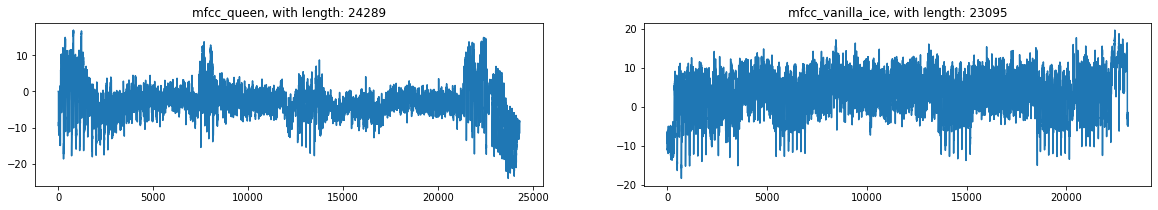

In [337]:
T_A = np.squeeze(data_dict["mfcc_queen"]).astype(np.float64)
T_B = np.squeeze(data_dict["mfcc_vanilla_ice"]).astype(np.float64)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 3))

axs[0].plot(T_A)
axs[0].set_title(f"mfcc_queen, with length: {len(T_A)}")

axs[1].plot(T_B)
axs[1].set_title(f"mfcc_vanilla_ice, with length: {len(T_B)}")

plt.show()

In [338]:
m = 300
stumpy.config.STUMPY_EXCL_ZONE_DENOM = 4 # not provided in MATLAB! But, I set it to 1!

In [339]:
mp_AB = stumpy.stump(T_A, m, T_B, ignore_trivial=False)
P_AB = np.min(mp_AB[:,0].astype(np.float64))

idx_A = np.argmin(P_AB)
idx_B = mp_AB[idx_A, 1] # this is NN of idx_A in T_B

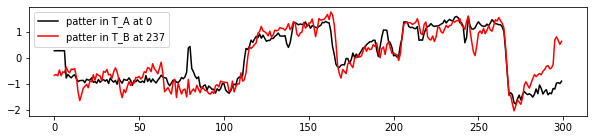

In [340]:
S_A = T_A[idx_A : idx_A + m]
S_B = T_B[idx_B : idx_B + m]

S_A = stumpy.core.z_norm(S_A)
S_B = stumpy.core.z_norm(S_B)

plt.figure(figsize=(10, 2))
plt.plot(S_A, color='k', label=f'patter in T_A at {idx_A}')
plt.plot(S_B, color='r', label=f'patter in T_B at {idx_B}')
plt.legend()
plt.show()

<a id='alignment'></a>
## 5. How do these two time series differ in terms of alignment?

This regards to detect the alignment between two time series. The proper tool is DTW. Since this is not in the scope of STUMPY API, we encourage reader to read the original document. A good tool for DTW can be found in tslearn.

<a id='motifs'></a>
## 6. Find the most conserved pattern that happens at least once every two days in this datase

Data is 14 days of  household electric load. We first chunk it to seven two-day series and then connect them back by using np.nan spacer.

In [364]:
data_dir = get_path_to_data_dir("Q6")
data_dict = scipy.io.loadmat(data_dir + 'TwoWeekElectrical.mat')

T = np.squeeze(data_dict['T']).astype(np.float64)
house1 = np.squeeze(data_dict['house1']).astype(np.float64)

In [365]:
T.shape # this is the data of our interest
r = len(T) % 7
T = T[:-r] # just getting rid of two data points to make the chunking process easier!

In [366]:
T_chunks = T.reshape(7, -1)
T_chunks.shape

(7, 22859)

In [383]:
m = 800 # two hours
stumpy.config.STUMPY_EXCL_ZONE_DENOM = 2

Tchunk_lst = []
for ts in T_chunks:
    Tchunk_lst.append(ts)

    
# if you do not have gpu, use stumpy.ostinato instead.
radius, Ts_idx, subseq_idx = stumpy.gpu_ostinato(Tchunk_lst, m) 

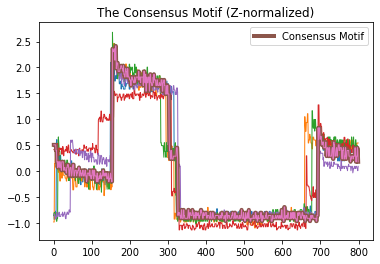

In [384]:
consensus_motif = Tchunk_lst[Ts_idx][subseq_idx : subseq_idx + m]
nn_idx = []
for i, Tchunk in enumerate(Tchunk_lst):
    nn_idx.append(np.argmin(stumpy.core.mass(consensus_motif, Tchunk)))
    lw = 1
    label = None
    if i == Ts_idx:
        lw = 4
        label = 'Consensus Motif'
    plt.plot(stumpy.core.z_norm(Tchunk[nn_idx[i] : nn_idx[i]+m]), lw=lw, label=label)

plt.title('The Consensus Motif (Z-normalized)')
plt.legend()
plt.show()